<a href="https://colab.research.google.com/github/fidanfatih/Fraud_Detection/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IEEE-CIS Fraud Detection 
[Kaggle Link](https://www.kaggle.com/c/ieee-fraud-detection/overview)

From the competition overview:

In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.

If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

You are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

`Categorical Features - Transaction`
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

`Categorical Features - Identity`
- DeviceType
- DeviceInfo
- id_12 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

`Files`

- train_{transaction, identity}.csv - the training set
- test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
- sample_submission.csv - a sample submission file in the correct format


Vesta Corporation provided the dataset for this competition. Vesta Corporation is the forerunner in guaranteed e-commerce payment solutions. Founded in 1995, Vesta pioneered the process of fully guaranteed card-not-present (CNP) payment transactions for the telecommunications industry. Since then, Vesta has firmly expanded data science and machine learning capabilities across the globe and solidified its position as the leader in guaranteed ecommerce payments. Today, Vesta guarantees more than $18B in transactions annually.

**1- Data Preprosessing**

- Import Modules
- Data Load and Integration
- Data Review and Understanding
- Memory reduction

**2- Exploratory Data Analysis (EDA)**
- summarize data
- drop redundant columns
- converting data to the same standard
- dtype transformation
- Data Visualization
- Insights & visual graphs
- Feature engineering
- Detect outliers  
- Handling missing values
- Frequency Encoding

**3- Model Building**
- Dimensionally reduction (PCA)
- Model Training (XGBoost, LightGBM)
- Model Evaluation

**4- Model Deployment**
- Save and Export the Model as .pkl
- Build a web interface with streamlit
- Model deployment on cloud

**5- Presentation & Article**
- Prepare a detailed notebook
- Write an article
- Release the article on medium.com
- Project presentation

### Read dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import multiprocessing


import re
import gc
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

Colaboratory, or Colab for short, is a Google Research product, which allows developers to write and execute Python code through their browser. Google Colab is an excellent tool for deep learning tasks. It is a hosted Jupyter notebook that requires no setup and has an excellent free version, which gives free access to Google computing resources such as GPUs and TPUs. So, We use Colab for the project.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


%%time is a magic command. It's a part of IPython. It prints the wall time for the entire cell whereas %time gives you the time for first line only. Using %%time prints 2 values:
- CPU Times
- Wall Time

In [3]:
%%time

files = ['/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/test_identity.csv.zip', 
         '/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/test_transaction.csv.zip',
         '/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_identity.csv.zip',
         '/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_transaction.csv.zip']

def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr = pool.map(load_data, files)

CPU times: user 3.67 s, sys: 5.77 s, total: 9.44 s
Wall time: 1min


In the competition the probability that an online transaction is fraudulent will be predicted, as denoted by the binary target isFraud.

Data is separated into two datasets: information about the identity of the customer and transaction information. Not all transactions belong to identities, which are available. Maybe it would be possible to use additional transactions to generate new features.

In [4]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

15

This kernel includes only the "Exploratory Data Analysis" phase. Because of this, The datasets exclude from "train/test" are deleted. It provides more memory and RAM capacity.

According to Python Official Documentation, you can explicitly invoke the Garbage Collector to release unreferenced memory with `gc.collect()`

In [5]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


So we have two medium-sized datasets with a lot of columns. Train and test data have similar number of rows

In [6]:
# Check for column mismatches
def diff(li1, li2):
    li1_dif = [i for i in li1 + li2 if i not in li1]
    li2_dif = [i for i in li1 + li2 if i not in li2]

    print(f"""not in list1:
{li1_dif}\n   
not in list2:
{li2_dif}""")

diff(sorted(train.columns), sorted(test.columns))

not in list1:
['id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06', 'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
   
not in list2:
['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud']


In [7]:
test.rename(columns=lambda x: x.replace("id-","id_") if "id-" in x else x, inplace=True)

We made the column names of the independent features the same.

## FUNCTIONS

#### Description Functions

In [8]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

In [9]:
!pip install colorama
def column_details(regex, df):
  # We will focus on each column in detail
  # Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
  global columns
  columns=[col for col in df.columns if re.search(regex, col)]

  from colorama import Fore, Back, Style

  print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
  for i in df[columns]:
      color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
      print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')
      

In [10]:
def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)

#### Plot Functions

In [11]:
def labels(ax, df, xytext=(0, 0)):
    for bar in ax.patches: 
        ax.annotate('%{:.2f}\n{:.0f}'.format(100*bar.get_height()/len(df),bar.get_height()), (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                    size=11, xytext=xytext, 
                    textcoords='offset points')

def plot_col(col, df, figsize=(20,6)):

    fig, ax = plt.subplots(1,2,figsize=figsize, sharey=True)

    plt.subplot(121)
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    ax[0] = sns.countplot(x=col, data=df, hue='isFraud', 
                  order=np.sort(df[col].dropna().unique()),
                  )
    ax[0].tick_params(axis='x', rotation=90)
    labels(ax[0],df[col].dropna(),(0, 0))
    
    ax_twin = ax[0].twinx()
    # sns.set(rc={"lines.linewidth": 0.7})
    ax_twin = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', legend=False, 
                  order = np.sort(df[col].dropna().unique()), 
                  linewidth=0.1)
    

    ax[0].grid()

    plt.subplot(122)
    ax[1] = sns.countplot(x=df[col].dropna(),
                  order= np.sort(df[col].dropna().unique()),
                  )
    ax[1].tick_params(axis='x', rotation=90)
    labels(ax[1],df[col].dropna())
    plt.show()


In [12]:
def plot_cols(regex, figsize, target, df):
  columns=[col for col in df.columns if re.search(regex, col)]
  nrow, ncolumn = len(columns),1

  fig, ax = plt.subplots(nrow, ncolumn,figsize=figsize)

  for i,col in enumerate(columns):
      order = np.sort(df[col].dropna().unique())
      
      plt.subplot(nrow,ncolumn,i+1)
      ax[i] = sns.countplot(x=df[col], data= df, hue=target, order = order)
  #     labels(ax[i],df[col].dropna(),(0,0))
      
      tmp = pd.crosstab(df[col], df[target], normalize='index') * 100
      tmp = tmp.reset_index()
      tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
      
      ax_twin = ax[i].twinx()
  #     sns.set(rc={"lines.linewidth": 1})
      ax_twin = sns.pointplot(x=tmp[col], y=tmp['Fraud'],color='black', order = order)
      ax[i].grid();

In [13]:
def hist_countplot(regex, figsize, nrow=10, ncolumn = 4, target='isFraud', df=pd.DataFrame()):
  plt.figure(figsize=figsize)
  columns=[col for col in df.columns if re.search(regex, col)]

  for i,col in enumerate(columns):
      plt.subplot(nrow,ncolumn,i+1)
      if df[col].dtype!='O':
          sns.histplot(x=df[col], data= df, hue=target)
      else:
          sns.countplot(x=df[col], data= df, hue=target) 

In [14]:
def box_countplot(regex, figsize, nrow=10, ncolumn = 4, target='isFraud', df=pd.DataFrame()):
  plt.figure(figsize=figsize)

  columns=[col for col in df.columns if re.search(regex, col)]

  for i,col in enumerate(columns):
      plt.subplot(nrow,ncolumn,i+1)
      if df[col].dtype!='O':
          sns.boxplot(y=df[col], data= df, x=target)
      else:
          sns.countplot(x=df[col])

In [15]:
def box_labels(ax, df, col1,col2):
    medians = df.groupby([col1])[col2].median().round(2)
    vertical_offset = df[col2].median() * 0.05 # offset from median for display

    for xtick in ax.get_xticks():
        ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
                horizontalalignment='center',size='small',color='w',weight='semibold')

#### Correlation Functions

In [16]:
# Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
#                 print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return drops

In [17]:
def corrank(X, threshold=0):
    import itertools
    df = pd.DataFrame([[i,j,X.corr().abs().loc[i,j]] for i,j in list(itertools.combinations(X.corr().abs(), 2))],columns=['Feature1','Feature2','corr'])    
    df = df.sort_values(by='corr',ascending=False).reset_index(drop=True)
    return df[df['corr']>threshold]

In [18]:
import scipy.stats as sts

# References:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#### Outlier Functions

In [19]:
def outliers(s):
  # summary of the outliers
  iqr = (np.quantile(s, 0.75))-(np.quantile(s, 0.25))
  upper_bound = np.quantile(s, 0.75)+(1.5*iqr)
  lower_bound = np.quantile(s, 0.25)-(1.5*iqr)
  f = []
  for i in s:
      if i > upper_bound:
          f.append(i)
      elif i < lower_bound:
          f.append(i)
  sums = len(f)
  pros = len(f)/len(s)*100
  d = {'IQR':iqr,
        'Upper Bound':upper_bound,
      'Lower Bound':lower_bound,
      'Sum outliers': sums,'percentage outliers':pros}
  d = pd.DataFrame(d.items(),columns = ['sub','values'])
  return(d)


In [20]:
def capping_outliers(col, whisker=1.5):
  # replace outliers with upper_bound and lower_bound values

  iqr = (np.quantile(df[col], 0.75))-(np.quantile(df[col], 0.25))
  upper_bound = np.quantile(df[col], 0.75)+(whisker*iqr)
  lower_bound = np.quantile(df[col], 0.25)-(whisker*iqr)

  df[col] = np.where(df[col] < upper_bound, 
                                upper_bound,df[col])
  df[col] = np.where(df[col] > lower_bound, 
                                lower_bound,df[col])
  plt.figure(figsize=(12,6))
  sns.boxplot(x= df[col]);
  return df[col]

In [21]:
def replace_outliers(col, replaced_value='median',whisker=1.5):
  # replace outliers with 'median','mean','mode' or an assigned value.

  iqr = (np.quantile(df[col], 0.75))-(np.quantile(df[col], 0.25))
  upper_bound = np.quantile(df[col], 0.75)+(whisker*iqr)
  lower_bound = np.quantile(df[col], 0.25)-(whisker*iqr)
  if replaced_value=='median':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].median())
    df[col] = df[col].mask(df[col] < lower_bound, df[col].median())
  elif replaced_value=='mean':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].mean())
    df[col] = df[col].mask(df[col] < lower_bound, df[col].mean())
  elif replaced_value=='mode':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].mode()[0])
    df[col] = df[col].mask(df[col] < lower_bound, df[col].mode()[0])
  else:
    df[col] = df[col].mask(df[col] > upper_bound, replaced_value)
    df[col] = df[col].mask(df[col] < lower_bound, replaced_value)   

  plt.figure(figsize=(12,6))
  sns.boxplot(x= df[col]);

  return df[col]

In [22]:
def col_plot(df,col_name):
    plt.figure(figsize=(15,6))
    
    plt.subplot(141) # 1 satir x 4 sutun dan olusan ax in 1. sutununda calis
    plt.hist(df[col_name], bins = 20)
    f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
    f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
    
    # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
    plt.axvline(x=df[col_name].mean() + 3*df[col_name].std(),color='red')
    plt.axvline(x=df[col_name].mean() - 3*df[col_name].std(),color='red')
    plt.xlabel(col_name)
    plt.tight_layout
    plt.xlabel("Histogram ±3z")
    plt.ylabel(col_name)

    plt.subplot(142)
    plt.boxplot(df[col_name]) # IQR katsayisi, defaultu 1.5
    plt.xlabel("IQR=1.5")

    plt.subplot(143)
    plt.boxplot(df[col_name].apply(f_sqrt), whis = 1.5)
    plt.xlabel("ROOT SQUARE - IQR=1.5")

    plt.subplot(144)
    plt.boxplot(df[col_name].apply(f_log), whis = 1.5)
    plt.xlabel("LOGARITMIC - IQR=1.5")
    plt.show()

In [23]:
def plot_winsorize(df,col_name,down=0, up=0.1):
    plt.figure(figsize = (15, 6))

    winsor=winsorize(df[col_name], (down,up))
    f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
    root_winsor=winsorize(df[col_name].apply(f_sqrt), (down,up))

    plt.subplot(141)
    plt.hist(winsor, bins = 22)
    plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
    plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
    plt.xlabel('Winsorize_Histogram')
    plt.ylabel(col_name)
    plt.tight_layout

    plt.subplot(142)
    plt.boxplot(winsor, whis = 1.5)
    plt.xlabel('Winsorize - IQR:1.5')
    
    plt.subplot(143)
    plt.hist(root_winsor, bins=22)
    plt.axvline(x=root_winsor.mean()+3*root_winsor.std(),color='red')
    plt.axvline(x=root_winsor.mean()-3*root_winsor.std(),color='red')
    plt.xlabel('root_winsor_col_name')

    plt.subplot(144)
    plt.boxplot(root_winsor, whis = 1.5)
    plt.xlabel("Root & Winsorize - IQR=1.5")
    plt.show() 

In [24]:
def plot_log_winsorize(df,col_name,up=0.1,down=0):
    plt.figure(figsize = (15, 6))

    winsor=winsorize(df[col_name], (down,up))
    f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
    log_winsor=winsorize(df[col_name].apply(f_log), (down,up))

    plt.subplot(141)
    plt.hist(winsor, bins = 22)
    plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
    plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
    plt.xlabel('Winsorize_Histogram')
    plt.ylabel(col_name)
    plt.tight_layout

    plt.subplot(142)
    plt.boxplot(winsor, whis = 1.5)
    plt.xlabel('Winsorize - IQR:1.5')
    
    plt.subplot(143)
    plt.hist(log_winsor, bins=22)
    plt.axvline(x=log_winsor.mean()+3*log_winsor.std(),color='red')
    plt.axvline(x=log_winsor.mean()-3*log_winsor.std(),color='red')
    plt.xlabel('log_winsor_col_name')

    plt.subplot(144)
    plt.boxplot(log_winsor, whis = 1.5)
    plt.xlabel("Log & Winsorize - IQR=1.5")
    plt.show()

In [25]:
def simplify_column(col, df, threshold=0.005, value='mode'):
  df[col] = df[col].replace(df[col].value_counts(dropna=True)[df[col].value_counts(dropna=True, normalize=True)<threshold].index,df[col].mode()[0] if value=='mode' else 'other')
  return df[col]

### Memory Reduction Functions

In [26]:
# Memory Reduction
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Encoders

In [27]:
# Label Encoding

from sklearn.preprocessing import LabelEncoder
# def label_encoder(df):
#   for col in df.columns:
#     if df[col].dtype=='object':
#       le = LabelEncoder()
#       df[col] = le.fit_transform(df[col])
#   return df


# from sklearn.preprocessing import LabelEncoder
def label_encoder(cat_cols, df):
  for col in cat_cols:
    # if df[col].dtype=='object':
    if col in df.columns:
      le = LabelEncoder()
      # le.fit(list(df[col].astype(str).values))
      df[col] = le.fit_transform(list(df[col].astype(str).values))
  return df

In [28]:
# Count Encoding 

# !pip install category_encoders 
# from category_encoders import CountEncoder
def count_encoder(cat_cols, X_train, X_test):
  for col in cat_cols:
    if col in X_train.columns:
      ce = CountEncoder()
      ce.fit(X_train[col])
      X_train[col] = X_train.join(ce.transform(X_train[col]).add_suffix('_count'))
      X_test[col] = X_test.join(ce.transform(X_test[col]).add_suffix('_count'))
  return X_train, X_test

In [29]:
# Frequency Encoding

def frequency_encoder(cat_cols, df):
  for col in cat_cols:
    if col in df.columns:
      df= df.join(df[col].map(df[col].value_counts(normalize=True)).to_frame().add_suffix('_freq'))
  return df


def frequency_encoding(train, test, columns, self_encoding=False):
    for col in columns:
        df = pd.concat([train[[col]], test[[col]]])
        fq_encode = df[col].value_counts(dropna=False, normalize=True).to_dict()
        if self_encoding:
            train[col] = train[col].map(fq_encode)
            test[col]  = test[col].map(fq_encode)            
        else:
            train[col+'_freq'] = train[col].map(fq_encode)
            test[col+'_freq']  = test[col].map(fq_encode)
    return train, test

### Modeling

In [30]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

## Exploratory Data Analysis (EDA)

  **FEATURES**
- **`isFraud` : binary, Target** 

- **`TransactionID`** : all unique 
<br># It is pure noise right now

- **`TransactionDT`** : time series
<br>Time from reference time point. VERY valuable column

- **`TransactionAmt`** : continous
<br>It has many unique values and has to be combined with other columns. The best score boost should come from TransactionDT->TransactionAmt combination

- **`P_emaildomain`** : categoric, 56 uniques
<br>It's possible to make subgroup feature from it or general group

- **`R_emaildomain`** : categoric, 59 uniques
<br>It's possible to make subgroup feature from it or general group

- **`DeviceType`** : categoric, 2 uniques
<br>

- **`DeviceInfo`** : categoric, 700 uniques
<br>

- **`ProductCD`** : categoric, 5 uniques
<br>100% categorical feature options to use: Frequency encoding/Target encoding/Combinations with other columns/Model categorical feature

- **`card1-6`** : categoric, numeric
<br>Categorical features with information about Client

- **`addr1-2`** : 
<br>addr1 - subzone / add2 - Country 

- **`dist1-2`** : numeric
<br>dist1 - local distance from merchant / dist2 - Country distance

- **`C1-14`** : numeric
<br>

- **`D1-15`** : numeric
<br>timedelta, such as days between previous transaction, etc. Minimal value will be same for each month and day but maximum and mean values will grow over time.

- **`M1-9`** : categoric
<br>

- **`V1-339`** : numeric, categoric
<br>

- **`id_01_38`** : numeric, categoric
<br>

Since almost all values of 'TransactionID' are unique, it is dropped.

In [31]:
train = train.drop('TransactionID', axis=1)
test = test.drop('TransactionID', axis=1)

#### Memory Reduction

Working with large data while training ML Models requires large RAM memory. To overcome this limitation, we used a function to reduce the memory footprint of the data. The general approach is to convert dtype of each feature ('int16', 'int32', 'int64', 'float16', 'float32', 'float64') to the lowest possible dtype.



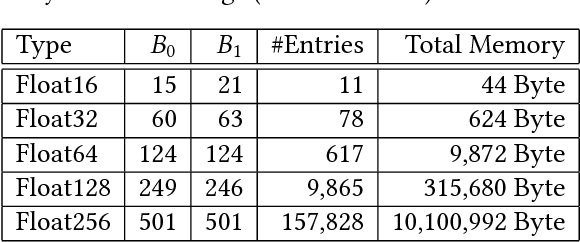

In [32]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
gc.collect()

Mem. usage decreased to 648.22 Mb (66.8% reduction)
Mem. usage decreased to 563.43 Mb (66.3% reduction)


0

In [33]:
train.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/train_1.pkl') 
test.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/test_1.pkl')

In [34]:
# train = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/train_1.pkl')
# test= pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/test_1.pkl')

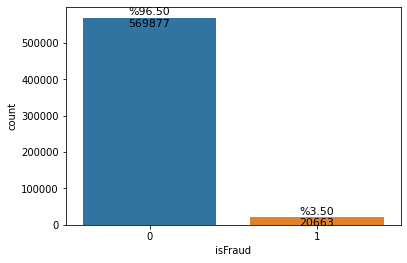

In [35]:
ax = sns.countplot(x='isFraud', data= train)
labels(ax, train)

3.5% of transacations are fraud. Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Imbalance means that the number of data points available for different the classes is different

### Handling missing values

In [36]:
missig_rate = np.product(train.isnull().sum().sum())/ np.product(train.shape)*100
print(f'missing value in train data: {missig_rate:.2f}%')

missig_rate = np.product(test.isnull().sum().sum())/ np.product(test.shape)*100
print(f'missing value in test data: {missig_rate:.2f}%')

missing value in train data: 45.18%
missing value in test data: 41.20%


Datasets have too much missing values.

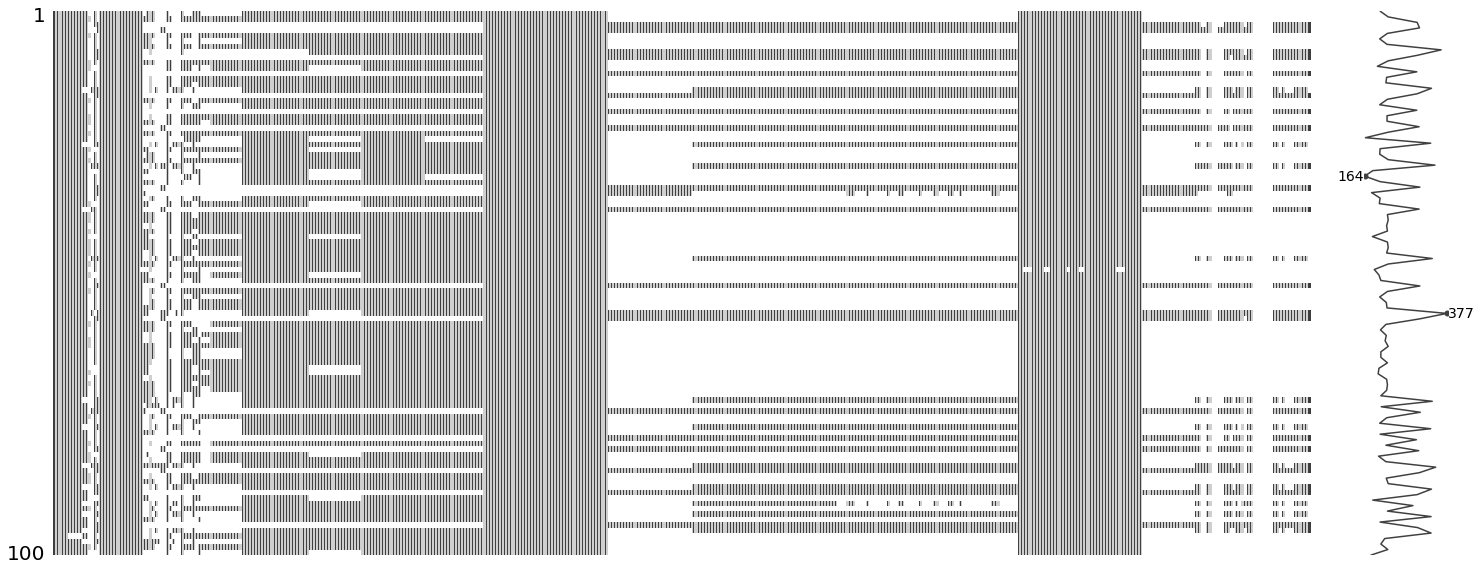

In [37]:
import missingno as msno
msno.matrix(train.sample(100));

When a sample took randomly, It is shown that many observations have "correlated missing values".

In [38]:
null_values(train, 90)

,Missing_Records,Percentage (%)
id_24,585793,99.196159
id_25,585408,99.130965
id_07,585385,99.127070
id_08,585385,99.127070
id_21,585381,99.126393
id_26,585377,99.125715
id_22,585371,99.124699
id_23,585371,99.124699
id_27,585371,99.124699
dist2,552913,93.628374


In [39]:
null_values(test, 90)

,Missing_Records,Percentage (%)
id_24,501951,99.064519
id_25,501652,99.005508
id_26,501644,99.003929
id_07,501632,99.001561
id_08,501632,99.001561
id_21,501632,99.001561
id_22,501629,99.000969
id_23,501629,99.000969
id_27,501629,99.000969
dist2,470255,92.809030


Columns having more than %90 missing values are listed above. There are some diffirences between test and train in terms of the missing values.


In [40]:
one_value_cols, many_null_cols, big_top_value_cols =[],[],[] 

for df in [train, test]:
  one_value_cols += [col for col in df.columns if df[col].nunique() == 1]
  many_null_cols += [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > 0.9]
  big_top_value_cols += [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(one_value_cols + many_null_cols + big_top_value_cols))

if 'isFraud' in cols_to_drop: 
  cols_to_drop.remove('isFraud')

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

print(f'{len(cols_to_drop)} features are going to be dropped for being useless')

82 features are going to be dropped for being useless


Columns containing only 1 unique value and containing more than 90 percent missing values and when missing values are dropped, columns with more than 90 percent of the remaining data are dropped from the dataset.

### TransactionDT

In [41]:
(train['TransactionDT']//(3600*24)).describe()

count    590540.000000
mean         84.729199
std          53.437277
min           1.000000
25%          35.000000
50%          84.000000
75%         130.000000
max         182.000000
Name: TransactionDT, dtype: float64

In [42]:
(test['TransactionDT']//(3600*24)).describe()

count    506691.000000
mean        311.086427
std          55.058802
min         213.000000
25%         263.000000
50%         314.000000
75%         362.000000
max         395.000000
Name: TransactionDT, dtype: float64

While train datasets are having observations for 182 days, test datasets are having observations for 183 days. There is a gap of 30 days between two datasets. We can generate some useful time-features from TransactionDT.

According to Wikipedia, feature engineering refers to the process of using domain knowledge to extract features from raw data via data mining techniques. These features can then be used to improve the performance of machine learning algorithms.
Feature engineering does not necessarily have to be fancy though. One simple, yet prevalent, use case of feature engineering is in time-series data. The importance of feature engineering in this realm is due to the fact that (raw) time-series data usually only contains one single column to represent the time attribute, namely date-time (or timestamp).
Regarding this date-time data, feature engineering can be seen as extracting useful information from such data as standalone (distinct) features. For example, from a date-time data of “2020–07–01 10:21:05”, we might want to extract the following features from it:

Month: 7

Day of month: 1

Day name: Wednesday (2020–07–01 was Wednesday)

Hour: 10

The minimum value in D columns has to equal the minimum value for each month and day. In order to meet this condition, the START_DATE has been determined as '2017-11-30'. Ref: https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda

In [43]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [44]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

In [45]:
for k, df in enumerate([train, test]):
  df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
  df['DT_M'] = ((df['DT'].dt.year-2017-k)*12 + df['DT'].dt.month).astype(np.int8).apply(lambda x: x%12 if x>12 else x)
  df['DT_W'] = ((df['DT'].dt.year-2017-k)*52 + df['DT'].dt.weekofyear).astype(np.int8).apply(lambda x: x%52 if x>52 else x)
  df['DT_D'] = ((df['DT'].dt.year-2017-k)*365 + df['DT'].dt.dayofyear).astype(np.int16).apply(lambda x: x%365 if x>365 else x)
  
  df['DT_hour'] = (df['DT'].dt.hour).astype(np.int8)
  df['DT_day_week'] = (df['DT'].dt.dayofweek).astype(np.int8)
  df['DT_day_month'] = (df['DT'].dt.day).astype(np.int8)

  # Holidays
  df['DT_holiday'] = (df['DT'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

In [193]:
train = train.drop('DT',axis=1)
test = test.drop('DT',axis=1)

In [46]:
for df in [train, test]:
  column_details(regex='^DT_.*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DT_M:  int64, 6, %0.0
[ 1  2  3  4  5 12]

DT_W:  int64, 27, %0.0
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 48 49
 50 51 52]

DT_D:  int64, 182, %0.0
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365]

DT_hour:  int8, 2

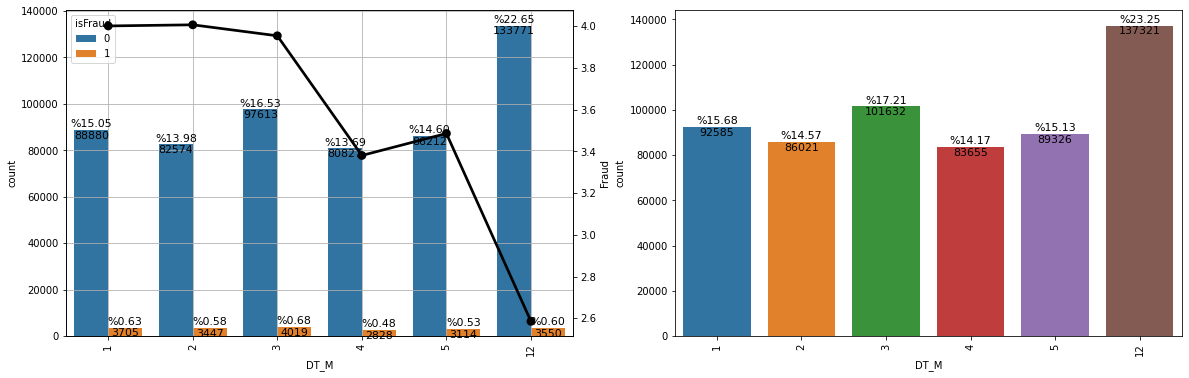

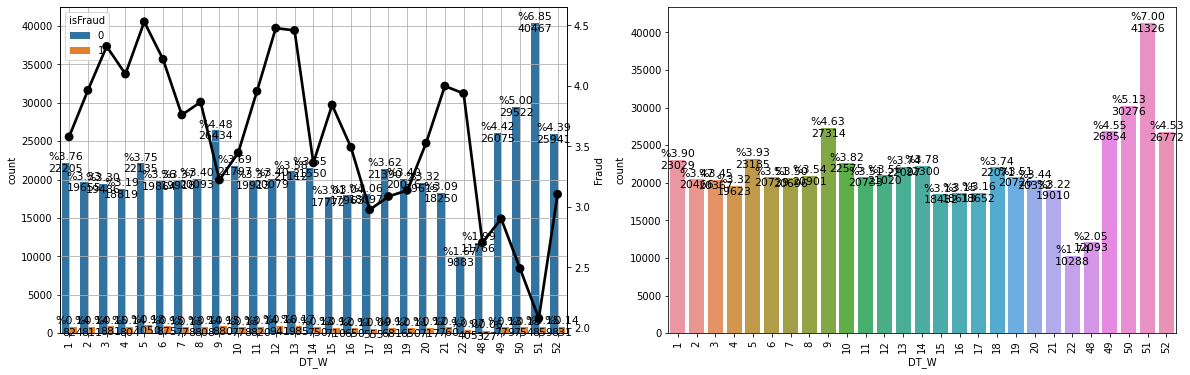

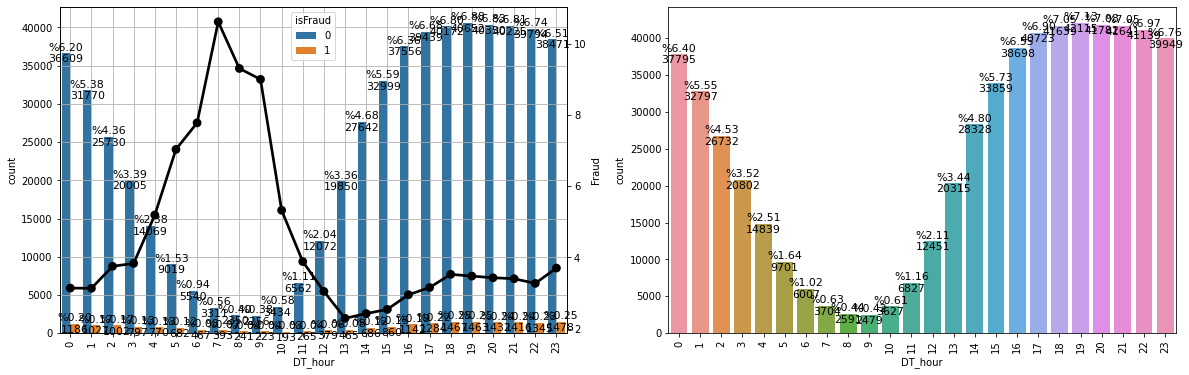

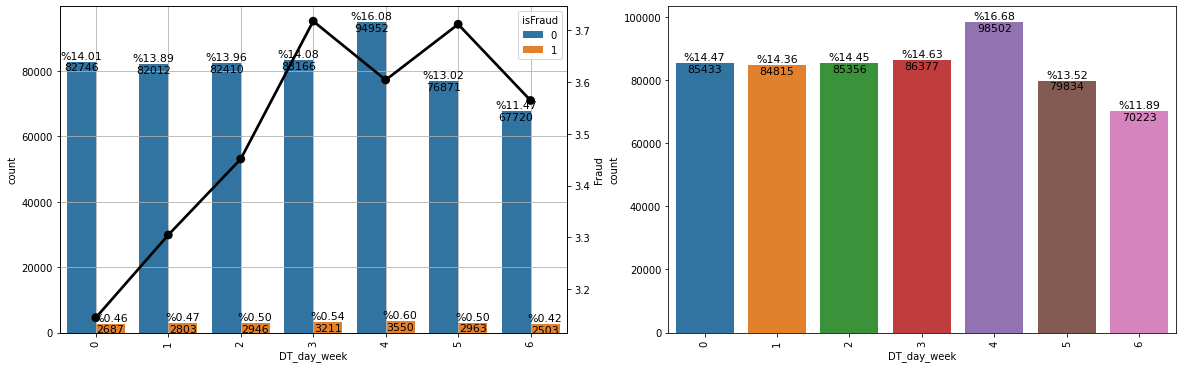

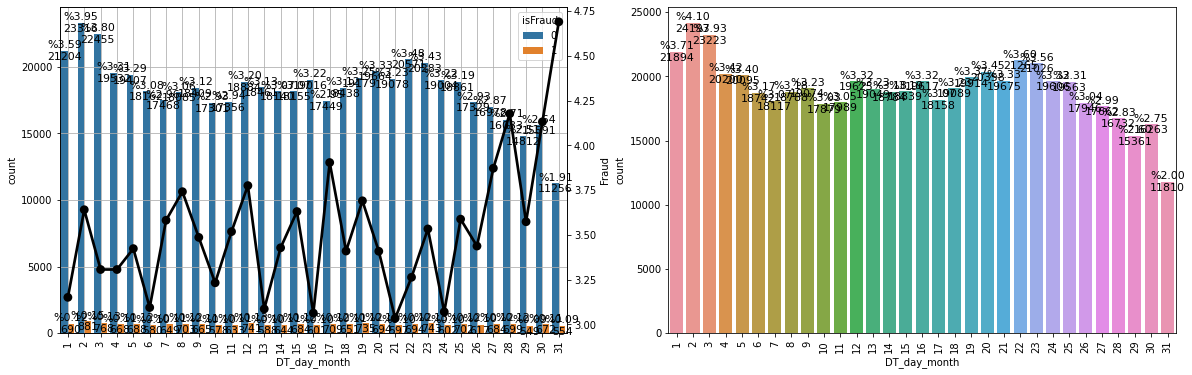

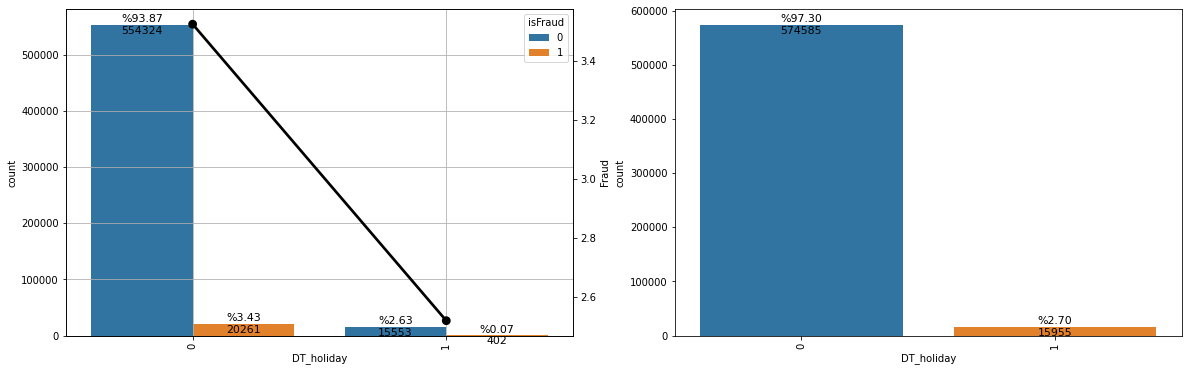

In [47]:
columns=[col for col in train.columns if re.search('^DT_.*', col)]
columns.remove('DT_D')

for col in columns:
  plot_col(col, df=train)

- In December, the Fraud rate decreased. December is the common month for both train and test datasets.
- In the morning hours, the fraud rate was high. Afternoon, It decreased.
- Fraud rate decreases towards the last days of the month, while decreasing during the holidays.
- Fraud rate tends to increase from the beginning of the week, tends to decrease on Friday and Sunday.

### TransactionAmt

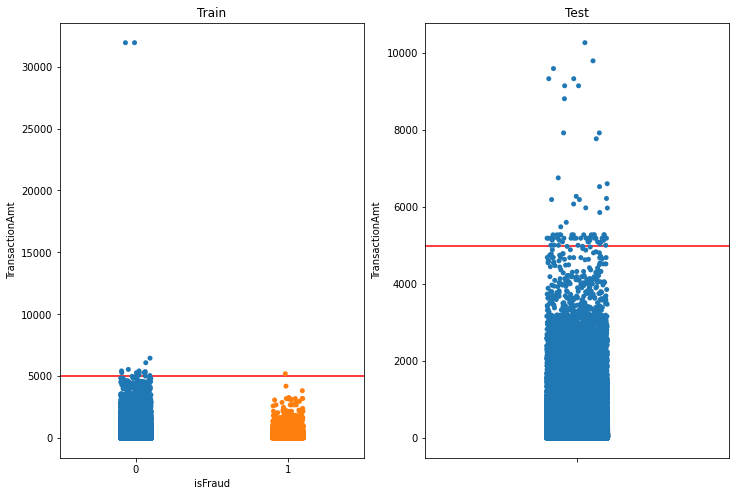

In [48]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='TransactionAmt', x='isFraud', data=train)
plt.axhline(5000, color='red')
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='TransactionAmt', data=test)
plt.axhline(5000, color='red')
plt.title('Test');

There is no transaction having a transaction amount of more than 5000. So we clipped them from 5000.

In [49]:
for df in [train, test]:
  df['TransactionAmt'] = df['TransactionAmt'].clip(0,5000)

In [50]:
train[train.isFraud==1]['TransactionAmt'].mean(), \
train[train.isFraud==0]['TransactionAmt'].mean(), \
train['TransactionAmt'].mean(), \
test['TransactionAmt'].mean()

(149.2360076904297, 134.26495361328125, 134.77645874023438, 134.49339294433594)

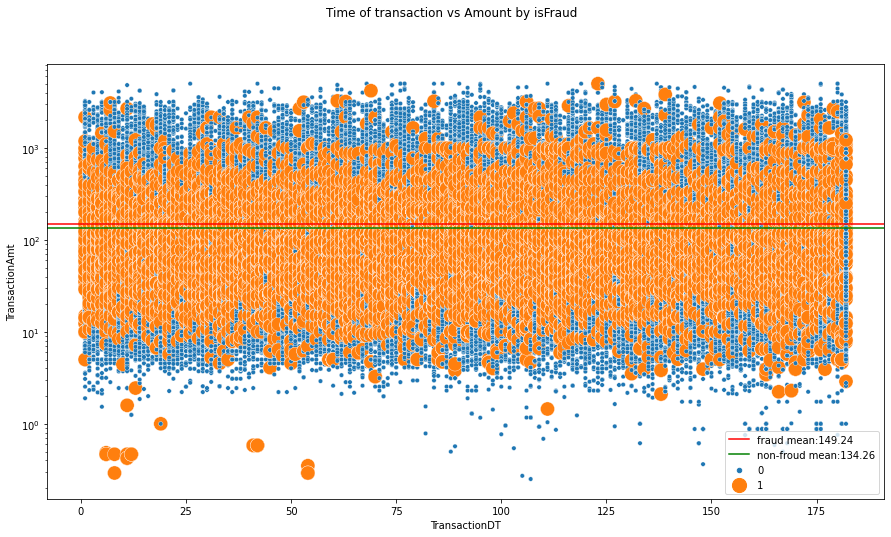

In [51]:
plt.figure(figsize=(15,8))
plt.suptitle('Time of transaction vs Amount by isFraud')
fraud_mean, nonfraud_mean = train[train.isFraud==1]['TransactionAmt'].mean(), train[train.isFraud==0]['TransactionAmt'].mean()
sns.scatterplot(x=train['TransactionDT']//(3600*24), y=train['TransactionAmt'], data=train, hue='isFraud', size="isFraud", sizes=(200, 20))
plt.axhline(y=fraud_mean ,color='red',label=f'fraud mean:{round(fraud_mean,2)}')
plt.axhline(y=nonfraud_mean, color='green',label=f'non-froud mean:{round(nonfraud_mean,2)}')
plt.legend()

plt.yscale('log')
plt.show()

The averages of TransactionAmt of train and test datasets are nearly same. The average of the fraud transactions(149.24) is bigger than the average of the non-fraud transactions(134.26).

### id_30

In [52]:
for df in [train, test]:
  column_details(regex='id_30', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

id_30:  object, 75, %86.87
['Android' 'Android 4.4.2' 'Android 5.0' 'Android 5.0.2' 'Android 5.1.1'
 'Android 6.0' 'Android 6.0.1' 'Android 7.0' 'Android 7.1.1'
 'Android 7.1.2' 'Android 8.0.0' 'Android 8.1.0' 'Linux' 'Mac'
 'Mac OS X 10.10' 'Mac OS X 10.11' 'Mac OS X 10.12' 'Mac OS X 10.13'
 'Mac OS X 10.6' 'Mac OS X 10.9' 'Mac OS X 10_10_5' 'Mac OS X 10_11_3'
 'Mac OS X 10_11_4' 'Mac OS X 10_11_5' 'Mac OS X 10_11_6' 'Mac OS X 10_12'
 'Mac OS X 10_12_1' 'Mac OS X 10_12_2' 'Mac OS X 10_12_3'
 'Mac OS X 10_12_4' 'Mac OS X 10_12_5' 'Mac OS X 10_12_6'
 'Mac OS X 10_13_1' 'Mac OS X 10_13_2' 'Mac OS X 10_13_3'
 'Mac OS X 10_13_4' 'Mac OS X 10_13_5' 'Mac OS X 10_6_8' 'Mac OS X 10_7_5'
 'Mac OS X 10_8_5' 'Mac OS X 10_9_5' 'Windows' 'Windows 10' 'Windows 7'
 'Windows 8' 'Windows 8.1' 'Windows Vista' 'Windows XP' 'func' 'iOS'
 'iOS 10.0.2' 'iOS 10.1.1' 'iOS 10.2.0' 'iOS 10.2.1' 'iOS 10.3.1'
 'iOS 10.3.2' 'iOS 10.3.3' 'iOS 11.0.0

In [53]:
old_versions_id_30 = set(train['id_30'].unique()) - set(test['id_30'].unique())
new_versions_id_30 = set(test['id_30'].unique()) - set(train['id_30'].unique())

Test dataset has some new software vesion that train dataset doesn't have. And also train dataset has a software vesion that test dataset doesn't have. We replace them with Nan value.

In [54]:
test['id_30'] =test['id_30'].apply(lambda x: np.nan if x in new_versions_id_30 else x)
train['id_30'] =train['id_30'].apply(lambda x: np.nan if x in old_versions_id_30 else x)

### id_31

In [55]:
for df in [train, test]:
  column_details(regex='id_31', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

id_31:  object, 130, %76.25
['BLU/Dash' 'Cherry' 'Generic/Android' 'Generic/Android 7.0' 'Inco/Minion'
 'LG/K-200' 'Lanix/Ilium' 'M4Tel/M4' 'Microsoft/Windows' 'Mozilla/Firefox'
 'Nokia/Lumia' 'Samsung/SCH' 'Samsung/SM-G531H' 'Samsung/SM-G532M'
 'ZTE/Blade' 'android' 'android browser 4.0' 'android webview 4.0' 'aol'
 'chrome' 'chrome 43.0 for android' 'chrome 46.0 for android'
 'chrome 49.0' 'chrome 49.0 for android' 'chrome 50.0 for android'
 'chrome 51.0' 'chrome 51.0 for android' 'chrome 52.0 for android'
 'chrome 53.0 for android' 'chrome 54.0 for android' 'chrome 55.0'
 'chrome 55.0 for android' 'chrome 56.0' 'chrome 56.0 for android'
 'chrome 57.0' 'chrome 57.0 for android' 'chrome 58.0'
 'chrome 58.0 for android' 'chrome 59.0' 'chrome 59.0 for android'
 'chrome 60.0' 'chrome 60.0 for android' 'chrome 61.0'
 'chrome 61.0 for android' 'chrome 62.0' 'chrome 62.0 for android'
 'chrome 62.0 for ios' 'chrome 63.0' 'chr

In [56]:
old_versions_id_31 = set(train['id_31'].unique()) - set(test['id_31'].unique())
new_versions_id_31 = set(test['id_31'].unique()) - set(train['id_31'].unique())

In [57]:
test['id_31'] =test['id_31'].apply(lambda x: np.nan if x in new_versions_id_31 else x)
train['id_31'] =train['id_31'].apply(lambda x: np.nan if x in old_versions_id_31 else x)

### id_33

In [58]:
old_versions_id_33 = set(train['id_33'].unique()) - set(test['id_33'].unique())
new_versions_id_33 = set(test['id_33'].unique()) - set(train['id_33'].unique())

In [59]:
test['id_33'] =test['id_33'].apply(lambda x: np.nan if x in new_versions_id_33 else x)
train['id_33'] =train['id_33'].apply(lambda x: np.nan if x in old_versions_id_33 else x)

### id_12-38

In [174]:
cramers_v(train.id_28,train.id_29), cramers_v(test.id_28,test.id_29)

0.977733347457673

In [175]:
train = train.drop('id_29', axis=1)
test = test.drop('id_29', axis=1)

id_28 and id_29 are having high correlation. (Treshold= 0.9). So we dropped 'id_29'

### V1-339

In [65]:
column_details(regex='V\d*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

V1:  float16, 2, %34.84
[ 0.  1. nan]

V2:  float16, 12, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]

V3:  float16, 12, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]

V4:  float16, 10, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  8.  9. 10. nan]

V5:  float16, 11, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. nan]

V6:  float16, 13, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. nan]

V7:  float16, 13, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. nan]

V8:  float16, 12, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]

V9:  float16, 12, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]

V10:  float16, 6, %34.84
[ 0.  1.  2.  3.  4.  5. nan]

V11:  float16, 8, %34.84
[ 0.  1.  2.  3.  4.  5.  6.  7. nan]

V12:  float16, 5, %2.48
[ 0.  1.  2.  3.  4. nan]

V13:  float16, 7, %2.48
[ 0.  1.  2.  3.  4.  5.  6. nan]

V15:  float16, 13, %2.48
[ 0

**V Columns subsets having similar NAN structures**

* V2-11
* V12-34
* V35-52
* V53-74
* V75-94
* V95-131
* V139-166
* V167-216
* V217-278
* V279-317
* V322-339

In [66]:
columns=[col for col in train.columns if re.search('^V\d*', col)]
len(columns)

270

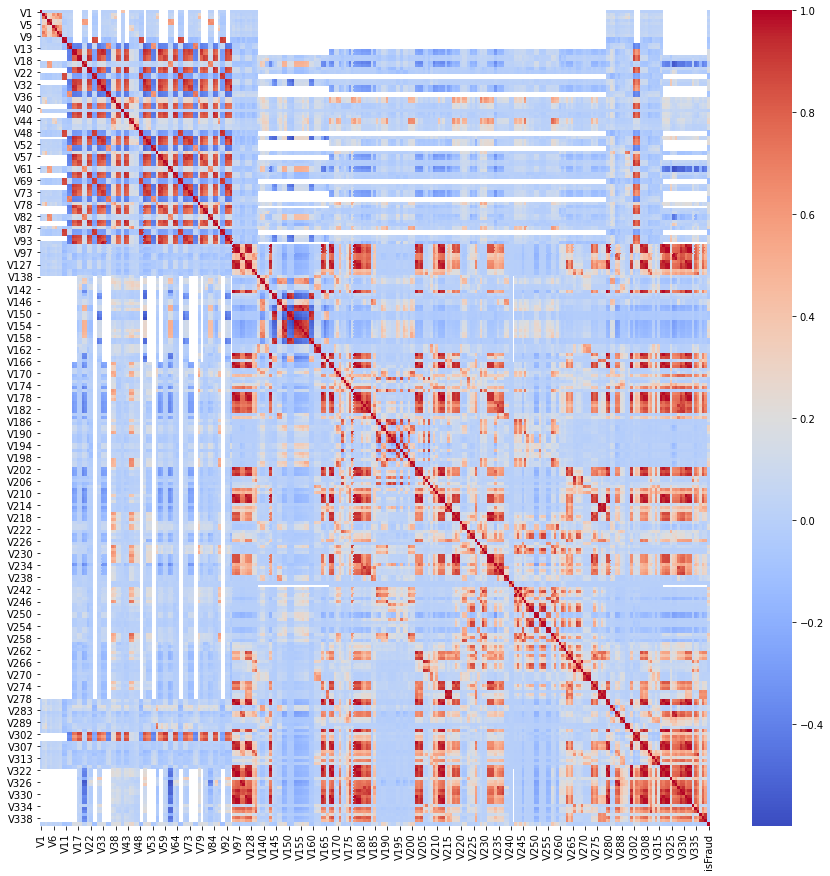

In [67]:
plt.figure(figsize=(15,15))
sns.heatmap(train[columns+['isFraud']].sample(frac=0.2).corr(),annot=False, cmap="coolwarm");

In [68]:
corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
len(drop_col)

208

In [69]:
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

In [70]:
columns=[col for col in train.columns if re.search('^V\d*', col)]
len(columns)

62

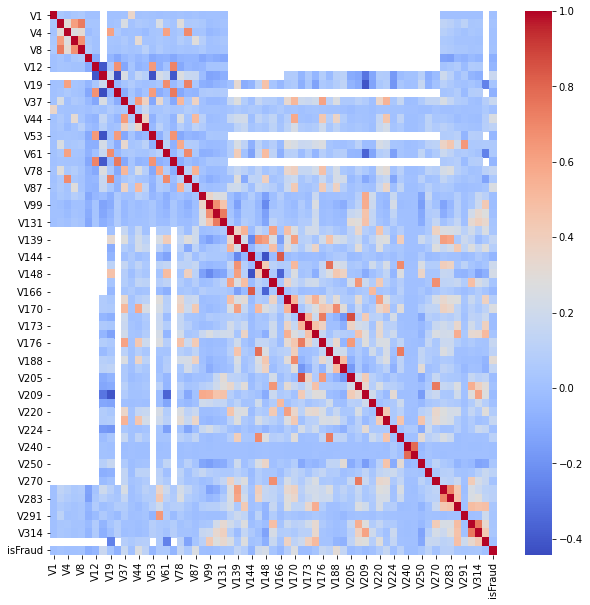

In [71]:
plt.figure(figsize=(10,10))
sns.heatmap(train[columns+['isFraud']].sample(frac=0.2).corr(),annot=False, cmap="coolwarm");

V columns seem redundant and related. Also, many subsets have similar NAN structures. We determined the columns with correlation (r > 0.75) in the V columns and dropped one of them, leaving only the independent columns. After dropping the correlated V columns, we have only 62 V columns.

### DeviceInfo

In [72]:
old_versions_DeviceInfo = set(train['DeviceInfo'].unique()) - set(test['DeviceInfo'].unique())
new_versions_DeviceInfo= set(test['DeviceInfo'].unique()) - set(train['DeviceInfo'].unique())

Test dataset has some new device that train dataset doesn't have. And also train dataset has a device that test dataset doesn't have. We replace them with Nan value.

In [73]:
test['DeviceInfo'] =test['DeviceInfo'].apply(lambda x: np.nan if x in new_versions_DeviceInfo else x)
train['DeviceInfo'] =train['DeviceInfo'].apply(lambda x: np.nan if x in old_versions_DeviceInfo else x)

### DeviceType

In [74]:
for df in [train, test]:
  column_details(regex='DeviceType', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceType:  object, 2, %76.16
['desktop' 'mobile' nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceType:  object, 2, %72.98
['desktop' 'mobile' nan]



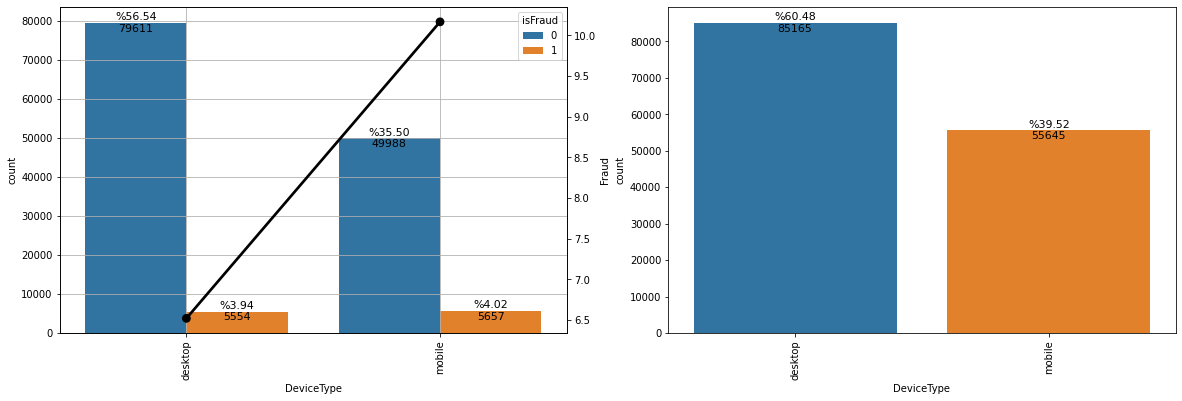

In [75]:
plot_col('DeviceType', df=train)

### R_emaildomain

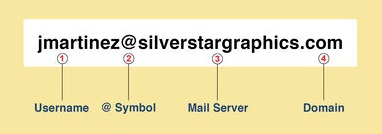

In [76]:
column_details(regex='R_emaildomain', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

R_emaildomain:  object, 60, %76.75
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'scranton.edu' 'servicios-ta.com' 'suddenlink.net' 'twc.com'
 'verizon.net' 'web.de' 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk'
 'yahoo.com' 'yahoo.com.mx' 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com'
 nan]



In [77]:
for df in [train, test]:
  df['R_emaildomain_1'] = df['R_emaildomain'].fillna('').apply(lambda x: x.split(".")[0]).replace({'':np.nan})
  df['R_emaildomain_2'] = df['R_emaildomain'].str.split('.', expand=True).iloc[:,1:].fillna('').apply(lambda x:('.'.join(x)).strip('.'), axis=1).replace({'':np.nan})

We produced 2 new columns with mail server and domain.

### P_emaildomain

In [78]:
column_details(regex='P_emaildomain', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

P_emaildomain:  object, 59, %15.99
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'servicios-ta.com' 'suddenlink.net' 'twc.com' 'verizon.net' 'web.de'
 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk' 'yahoo.com' 'yahoo.com.mx'
 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com' nan]



In [79]:
for df in [train, test]:
  df['P_emaildomain_1'] = df['P_emaildomain'].fillna('').apply(lambda x: x.split(".")[0]).replace({'':np.nan})
  df['P_emaildomain_2'] = df['P_emaildomain'].str.split('.', expand=True).iloc[:,1:].fillna('').apply(lambda x:('.'.join(x)).strip('.'), axis=1).replace({'':np.nan})

We produced 2 new columns with mail server and domain.

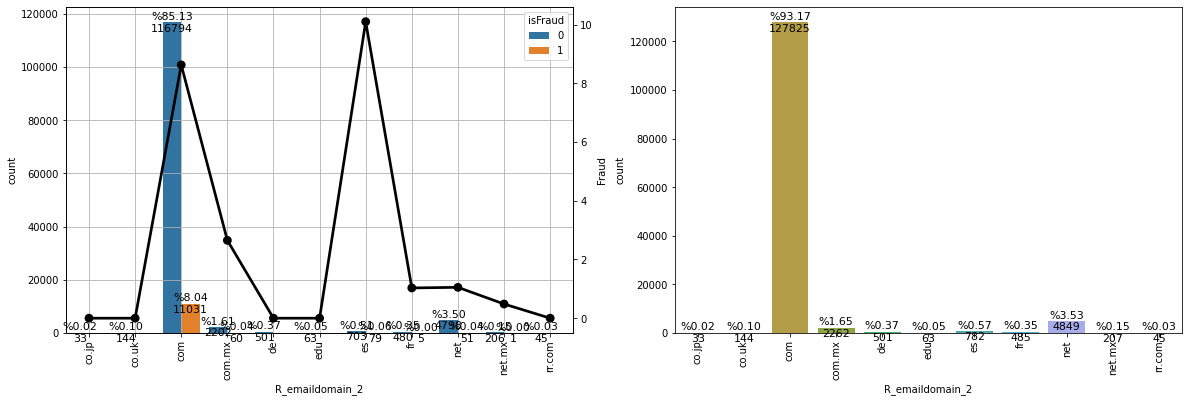

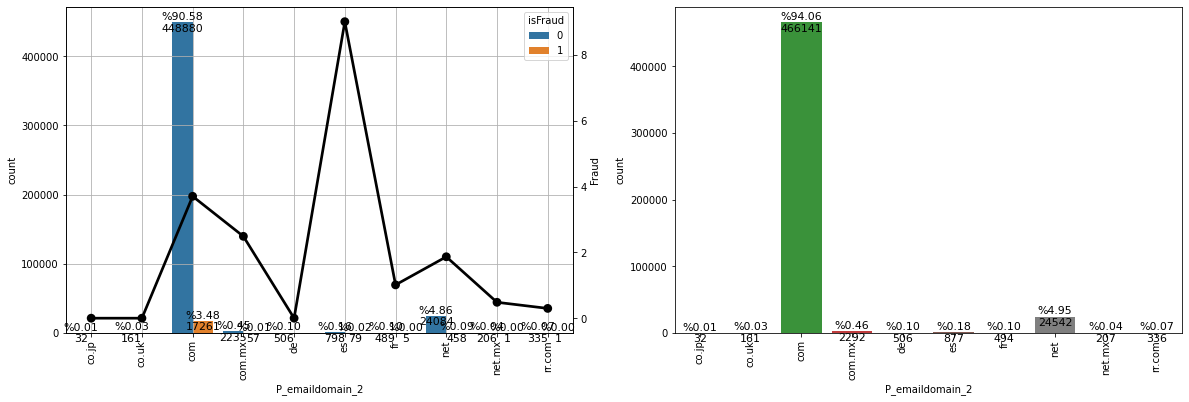

In [80]:
for col in ['R_emaildomain_2', 'P_emaildomain_2']:
  plot_col(col, df=train)

In [81]:
cramers_v(train.R_emaildomain_2,train.P_emaildomain_2)

0.8911182952794453

In [82]:
cramers_v(test.R_emaildomain_2,test.P_emaildomain_2)

0.9053937957212637

In [191]:
train = train.drop(['R_emaildomain','P_emaildomain','P_emaildomain_2'], axis=1)
test = test.drop(['R_emaildomain','P_emaildomain','P_emaildomain_2'], axis=1)

R_emaildomain_2 and P_emaildomain_2 are categorically 90% correlated. So we dropped P_emaildomain_2.

### addr1-2

In [84]:
for df in [train, test]:
  column_details(regex='addr', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

addr1:  float16, 332, %11.13
[100. 101. 102. 104. 105. 106. 110. 111. 112. 113. 117. 119. 120. 122.
 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 137. 139.
 141. 142. 143. 144. 145. 146. 148. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164. 166. 167. 168. 170. 171. 172. 174.
 177. 178. 180. 181. 182. 183. 184. 185. 187. 189. 190. 191. 193. 194.
 195. 196. 198. 199. 200. 201. 202. 203. 204. 205. 206. 208. 210. 211.
 213. 214. 215. 216. 217. 218. 219. 220. 221. 223. 224. 225. 226. 227.
 231. 232. 233. 234. 235. 236. 237. 238. 239. 241. 242. 243. 244. 245.
 247. 248. 249. 250. 251. 252. 253. 254. 255. 257. 258. 259. 260. 261.
 262. 264. 265. 268. 269. 270. 272. 274. 275. 276. 277. 278. 279. 280.
 282. 283. 284. 286. 290. 292. 294. 295. 296. 297. 298. 299. 300. 301.
 302. 303. 304. 305. 306. 307. 308. 309. 310. 312. 313. 314. 315. 316.
 318. 321. 322. 323. 324. 325. 326. 327. 328. 329. 3

In [85]:
for df in [train, test]:
  df['addr'] = (df['addr2'].astype(str)+'_'+df['addr1'].astype(str)).replace({'nan_nan':np.nan})

In [86]:
train['addr1'].nunique(), train['addr2'].nunique(), train['addr'].nunique()

(332, 74, 437)

In [87]:
test['addr1'].nunique(), test['addr2'].nunique(), test['addr'].nunique()

(292, 72, 394)

addr1 and addr2 are realted with adress. add2 - Country / addr1 - subzone. By combining them, we create a new column

### card1

In [88]:
gc.collect()

26909

In [89]:
old_versions_card1 = set(train['card1'].unique()) - set(test['card1'].unique())
new_versions_card1 = set(test['card1'].unique()) - set(train['card1'].unique())

In [90]:
len(old_versions_card1), len(new_versions_card1)

(3847, 3538)

In [91]:
test['card1'] =test['card1'].apply(lambda x: np.nan if x in new_versions_card1 else x)
train['card1'] =train['card1'].apply(lambda x: np.nan if x in old_versions_card1 else x)

We synchronized test['card1] and train[card1]

In [92]:
rareCards=[]
for k, df in enumerate([train, test]):
  rare_cards = df.card1.value_counts()
  rare_cards = rare_cards.where(rare_cards<3).dropna().sort_index().index
  rareCards += list(rare_cards)

  print(f"{('TEST' if k else 'TRAIN')}")
  print(f"Number of unique in card1: {df.card1.nunique()}")
  print(f"Number of unique values with frequency less than 3 in card1: {len(rare_cards)}\n")
rareCards = set(rareCards)

TRAIN
Number of unique in card1: 9706
Number of unique values with frequency less than 3 in card1: 2344

TEST
Number of unique in card1: 9706
Number of unique values with frequency less than 3 in card1: 2635



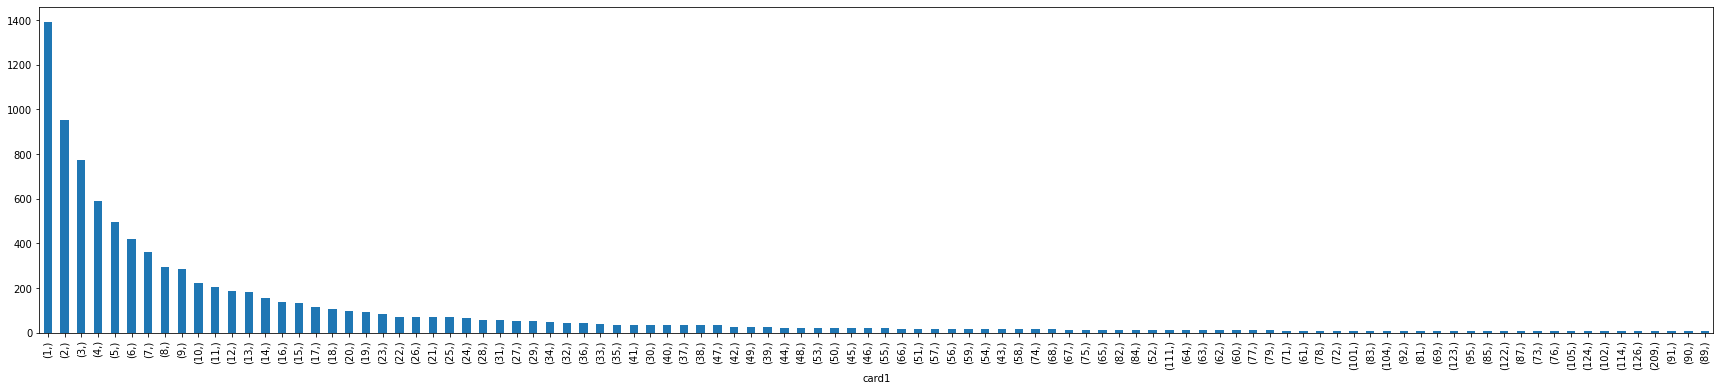

In [93]:
# Countplot of the frequency of the unique value frequencies in card1
plt.figure(figsize=(30,6))
train.card1.value_counts().to_frame().value_counts().head(100).plot.bar();

In [94]:
for df in [train, test]:
  df['card1'] = df['card1'].apply(lambda x: np.nan if x in rareCards else x)

We replaced "rare card1 values" with Nan.

### card2-6

In [95]:
column_details(regex='^card', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

card1:  float64, 6118, %3.74
[ 1004.  1006.  1008. ... 18393. 18395.    nan]

card2:  float16, 500, %1.51
[100. 101. 102. 103. 104. 105. 106. 108. 109. 110. 111. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156.
 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184.
 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198.
 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212.
 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226.
 227. 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240.
 241. 242. 243. 244. 245. 246. 247. 248. 249. 250. 251. 252. 253. 254.
 255. 256. 257. 258. 259. 260. 261. 262. 263. 

In [96]:
for col in ['card2','card3','card4','card5','card6']: 
  old_versions_col= set(train[col].unique()) - set(test[col].unique())
  new_versions_col = set(test[col].unique()) - set(train[col].unique()) 
  test[col] =test[col].apply(lambda x: np.nan if x in new_versions_col else x)
  train[col] =train[col].apply(lambda x: np.nan if x in old_versions_col else x)

### D8-9

In [97]:
null_values(train[['D8','D9']])

,Missing_Records,Percentage (%)
D8,515614,87.31229
D9,515614,87.31229


D8 and D9 have the same missing value rate in train and test dataset. They have to be related with each other.

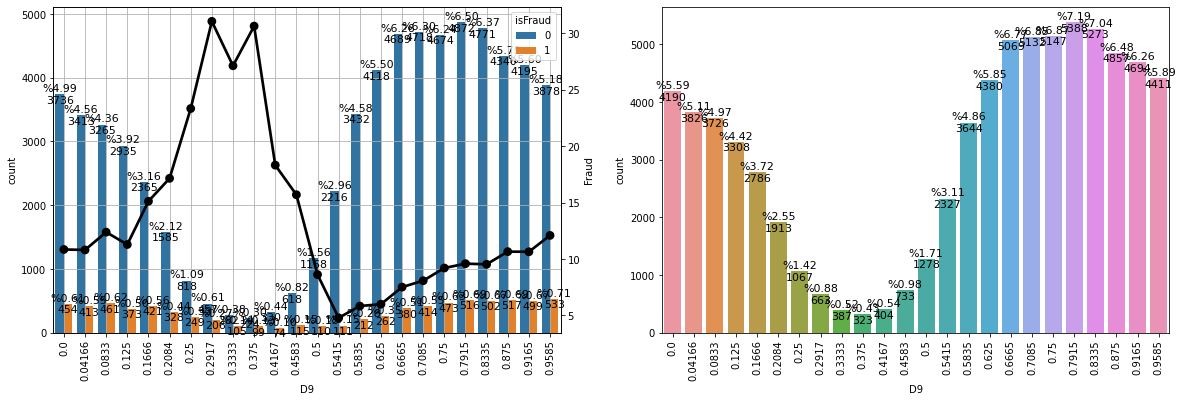

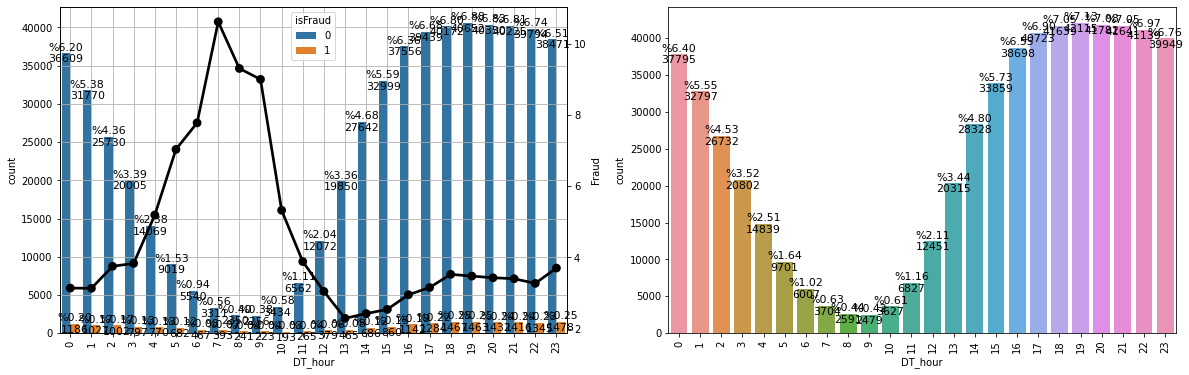

In [98]:
for col in ['D9','DT_hour']:
  plot_col(col, df=train)

In [99]:
train[['D9', 'DT_hour']].corr()

,D9,DT_hour
D9,1.0,1.0
DT_hour,1.0,1.0


D9 and DT_hour are having similar distribution. D9 must be related with hour.

In [100]:
train.D8.describe()

count    74926.000000
mean              NaN
std               NaN
min          0.000000
25%          0.958496
50%         37.875000
75%        188.000000
max       1708.000000
Name: D8, dtype: float64

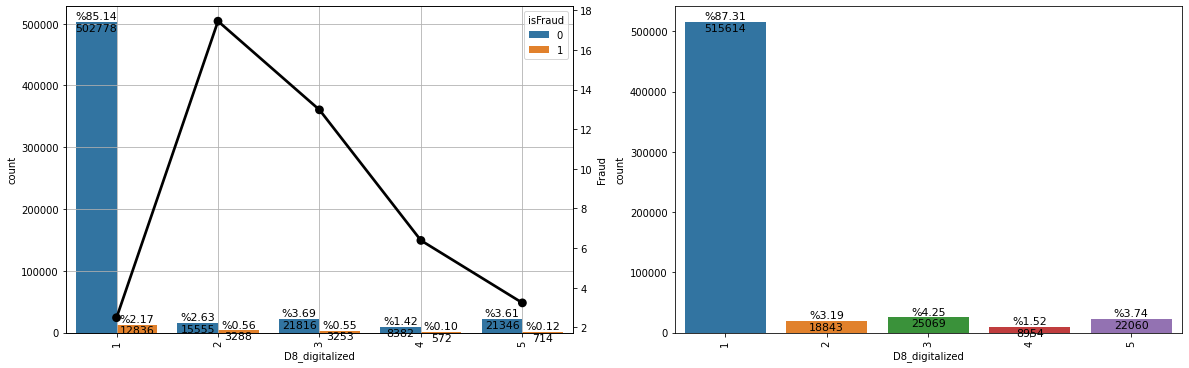

In [101]:
for df in [train, test]:
  df['D8_digitalized'] = pd.Series(np.digitize(df['D8'].fillna(-1), bins=[-1,0,1,75,150,1710]))
  df['D8'] = df['D8'].fillna(-1).astype(int)

plot_col('D8_digitalized', df=train)

### D1-15

In [102]:
for df in [train, test]:
  column_details(regex='^D\d.*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

D1:  float16, 641, %0.21
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 

The distribution of D8 is intense between 0 and 1. So we digitized D8 columns in order to find out a meaningful pattern.

In [103]:
columns=[col for col in train.columns if re.search('^D\d.*', col)]+['DT_hour']

corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
drop_col

{'D12', 'D15', 'D2', 'D6', 'DT_hour'}

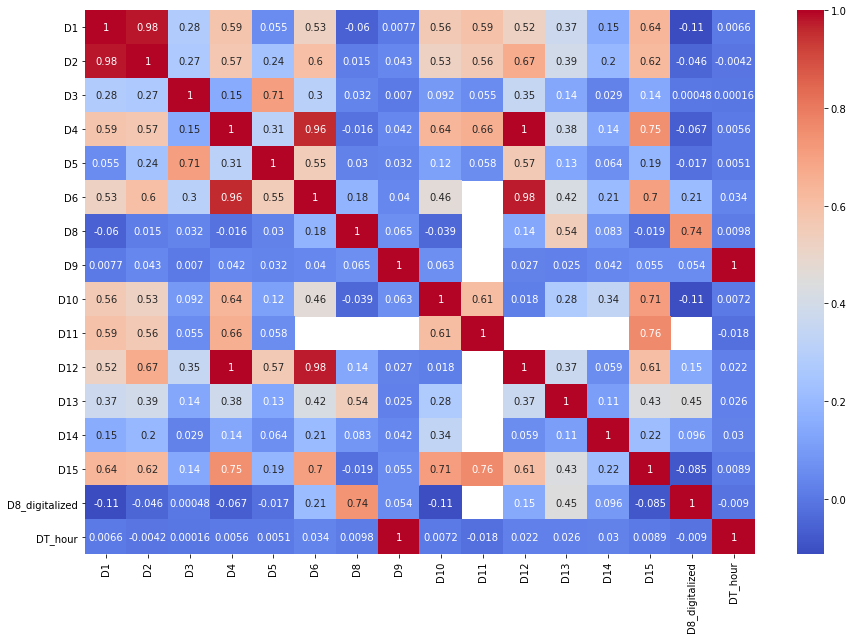

In [104]:
plt.figure(figsize=(15,10))
sns.heatmap(train[columns].corr(),annot=True, cmap="coolwarm");

The correlated columns having the most missing values are dropped. So, we replaced some columns in the dropping column list below.

In [107]:
drop_col={'D12', "D11", 'D2', 'D6', 'D9'}

In [108]:
for df in [train, test]:
  df = df.drop(drop_col, axis=1)

### C1-14

In [109]:
column_details(regex='^C\d', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

C1:  float16, 1495, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 4.672e+03 4.680e+03 4.684e+03]

C2:  float16, 1167, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 5.624e+03 5.688e+03 5.692e+03]

C4:  float16, 1223, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 2.248e+03 2.250e+03 2.252e+03]

C5:  float16, 319, %0.0
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.

In [110]:
columns=[col for col in train.columns if re.search('^C\d.*', col)]
corr_treshold = 0.9
drop_col = remove_collinear_features(train[columns],corr_treshold)
drop_col

{'C10', 'C11', 'C12', 'C14', 'C2', 'C4', 'C6', 'C7', 'C8', 'C9'}

In [111]:
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

One of the columns having more than %90 correlation are dropped.

### dist1-2

In [112]:
column_details(regex='^dist', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

dist1:  float16, 1918, %57.47
[0.000e+00 1.000e+00 2.000e+00 ... 7.384e+03 8.080e+03       nan]



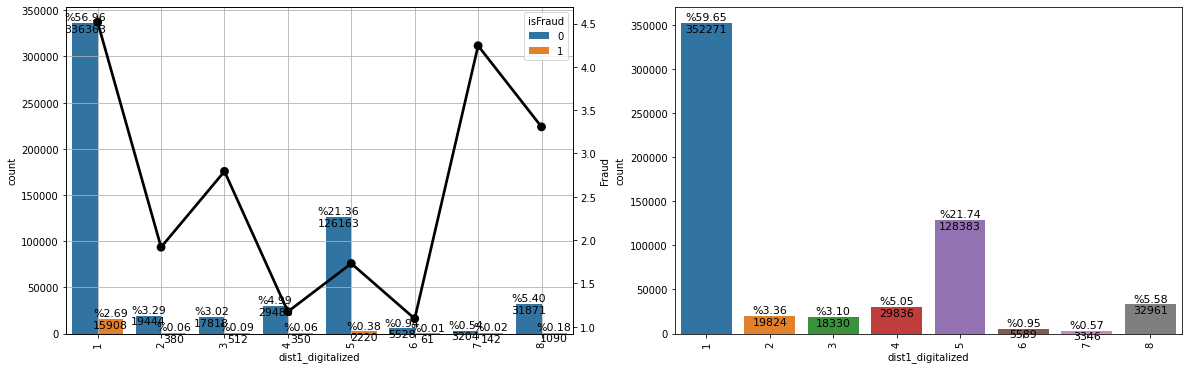

In [115]:
for df in [train, test]:  
  df['dist1_digitalized'] = pd.Series(np.digitize(df['dist1'].fillna(-1), bins=[-1,0,1,2,4,50,75,100,10300]))

plot_col('dist1_digitalized', df=train)

In [116]:
  train = train.drop('dist1', axis=1)
  test = test.drop('dist1', axis=1)

### M1-9

In [140]:
column_details(regex='^M\d*', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

M1:  object, 2, %45.91
['F' 'T' nan]

M2:  object, 2, %45.91
['F' 'T' nan]

M3:  object, 2, %45.91
['F' 'T' nan]

M4:  object, 3, %47.66
['M0' 'M1' 'M2' nan]

M5:  object, 2, %59.35
['F' 'T' nan]

M6:  object, 2, %28.68
['F' 'T' nan]

M7:  object, 2, %58.64
['F' 'T' nan]

M8:  object, 2, %58.63
['F' 'T' nan]

M9:  object, 2, %58.63
['F' 'T' nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

M1:  object, 2, %34.86
['F' 'T' nan]

M2:  object, 2, %34.86
['F' 'T' nan]

M3:  object, 2, %34.86
['F' 'T' nan]

M4:  object, 3, %46.92
['M0' 'M1' 'M2' nan]

M5:  object, 2, %61.11
['F' 'T' nan]

M6:  object, 2, %31.37
['F' 'T' nan]

M7:  object, 2, %46.38
['F' 'T' nan]

M8:  object, 2, %46.38
['F' 'T' nan]

M9:  object, 2, %46.38
['F' 'T' nan]



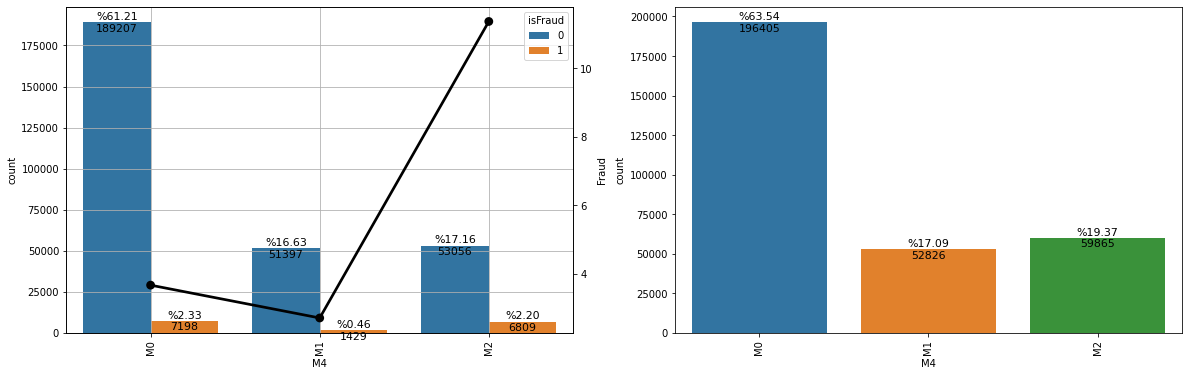

In [141]:
plot_col('M4', df=train)

In [142]:
temp_dict = train.groupby(['M4'])['isFraud'].agg(['mean']).to_dict()['mean']
train['M4_target_mean'] = train['M4'].replace(temp_dict)
test['M4_target_mean']  = test['M4'].replace(temp_dict)

We generated a new feature from 'M4' according to the mean of the target feature.

### ProductCD

In [119]:
for df in [train, test]:
  column_details(regex='ProductCD', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

ProductCD:  object, 5, %0.0
['C' 'H' 'R' 'S' 'W']

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

ProductCD:  object, 5, %0.0
['C' 'H' 'R' 'S' 'W']



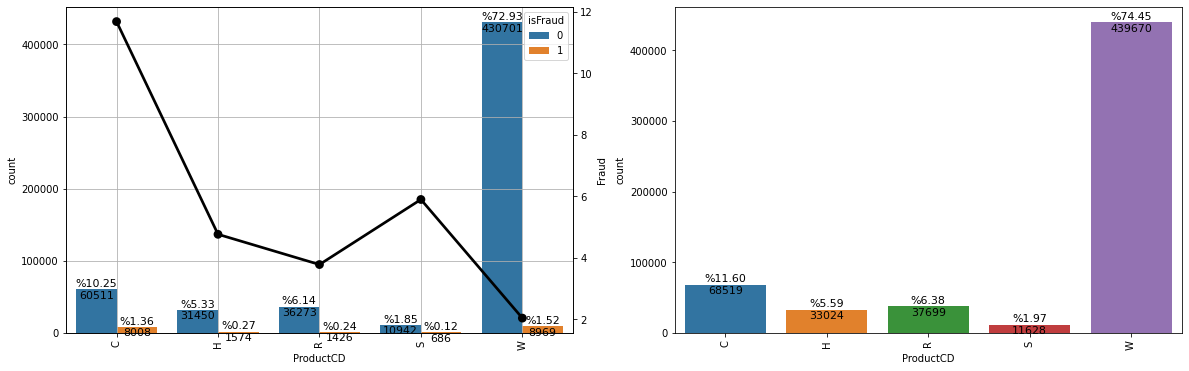

In [120]:
plot_col('ProductCD', df=train)

- For now we don't know exactly what these values represent.
- W has the most number of observations, C the least.
- ProductCD C has the most fraud with >11%
- ProductCD W has the least with ~2%

In [137]:
temp_dict = train.groupby(['ProductCD'])['isFraud'].agg(['mean']).to_dict()['mean']
train['ProductCD_target_mean'] = train['ProductCD'].replace(temp_dict)
test['ProductCD_target_mean']  = test['ProductCD'].replace(temp_dict)

We generated a new feature from 'ProductCD' according to the mean of the target feature.

### Frequency Encoders

One hot encoding was not used to get rid of the curse of multidimensionality. Although label encoding is a good solution for ordinal categorical data, it is not a suitable solution for nominal categorical data. It can be said that frequency encoding is the best solution for this data.

In [186]:
self_encode_True= ['ProductCD', 'DeviceInfo', 'DeviceType', 'addr'] + \
                  ['R_emaildomain_1', 'R_emaildomain_2','P_emaildomain_1'] + \
                  ['id_12','id_15','id_16','id_28','id_30','id_31','id_33',"id_34",'id_35', 'id_36', 'id_37', 'id_38'] + \
                  ['M1','M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']+ \
                  ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15'] + \
                  [ 'card4', 'card6']

self_encode_False=['card1', 'card2', 'card3', 'card5']+ \
                  ['C1', 'C5', 'C13']

In [188]:
train, test = frequency_encoding(train, test, self_encode_True, self_encoding=True)
train, test = frequency_encoding(train, test, self_encode_False, self_encoding=False)

In [ ]:
train.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/train_2.pkl') 
test.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/test_2.pkl')

# train= pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/train_2.pkl') 
# test= pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/test_2.pkl')

gc.collect()

### PCA for V Columns

With so many features, the performance of your algorithm will drastically degrade. PCA is a very common way to speed up your Machine Learning algorithm by getting rid of correlated variables which don’t contribute in any decision making. The training time of the algorithms reduces significantly with less number of features. 
In addition, Overfitting mainly occurs when there are too many variables in the dataset. So, PCA helps in overcoming the overfitting issue by reducing the number of features.

So, if the input dimensions are too high, then using PCA to speed up the algorithm is a reasonable choice. Now we will apply PCA to the V columns of 62 features. We are looking for a requirement that it represents more than 90% of the data.

In [205]:
V_columns = [col for col in train.columns if re.search('^V\d*', col)]
train[V_columns] = train[V_columns].fillna(-1)
test[V_columns] = test[V_columns].fillna(-1)

sc_V = MinMaxScaler()
sc_V.fit(train[V_columns])
train[V_columns] = sc_V.transform(train[V_columns])
test[V_columns] = sc_V.transform(test[V_columns])

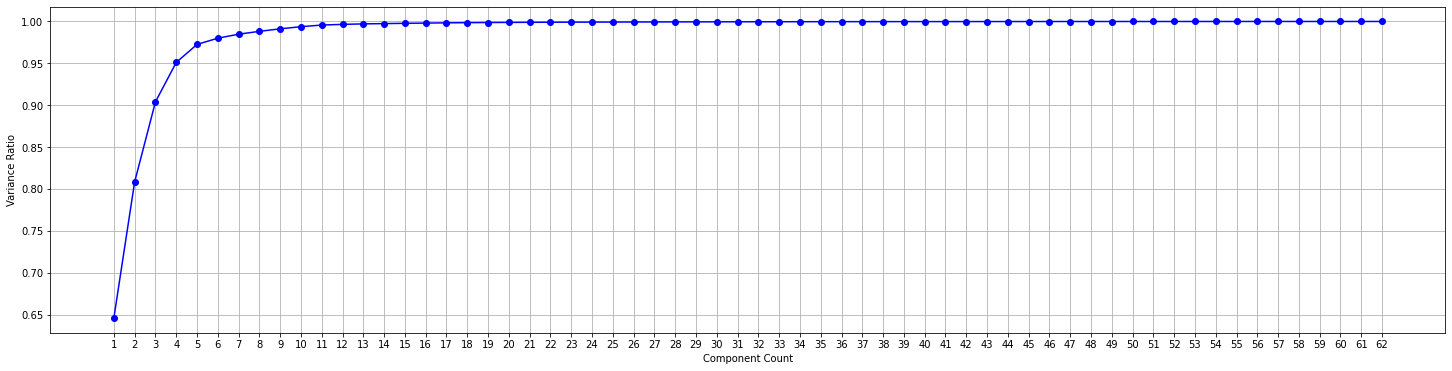

In [207]:
df = pd.concat([train, test], ignore_index=True, sort=False)

plt.figure(figsize=(25,6))
pca = PCA().fit(df[columns])
x = range(1,63)
plt.plot(x,np.cumsum(pca.explained_variance_ratio_), "bo-")
plt.xlabel("Component Count")
plt.ylabel("Variance Ratio")
plt.xticks(range(1,df[columns].shape[1]+1))
plt.grid()
plt.show()

In [208]:
del df

In [209]:
pca = PCA(n_components = 3)
pca.fit(train[V_columns])
pca_V_train = pca.transform(train[V_columns])
pca_V_test = pca.transform(test[V_columns])

np.cumsum(pca.explained_variance_ratio_)

array([0.6453108 , 0.805592  , 0.92127231])

In [210]:
gc.collect()

6287

In [211]:
pca_V_train = pd.DataFrame(data = pca_V_train).add_prefix('pca_V')
train = pd.concat([train, pca_V_train], ignore_index=False, sort=False, axis=1)
train.drop(V_columns, axis=1, inplace=True)

pca_V_test = pd.DataFrame(data = pca_V_test).add_prefix('pca_V')
test = pd.concat([test, pca_V_test], ignore_index=False, sort=False, axis=1)
test.drop(V_columns, axis=1, inplace=True)


In [212]:
del pca_V_train, pca_V_test

In [ ]:
train = train.drop('TransactionDT',axis=1)
test = test.drop('TransactionDT',axis=1)

In [335]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

train.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/train_3.pkl') 
test.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/test_3.pkl')

gc.collect()

Mem. usage decreased to 103.06 Mb (3.2% reduction)
Mem. usage decreased to 87.95 Mb (3.2% reduction)


0

### Export Data

In [295]:
# train= pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/train_3.pkl') 
# test= pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/test_3.pkl')

## Modeling with LightGBM

Gradient Boosting Decision Trees (GBDT) algorithms have been proven to be among the best algorithms in machine learning. XGBoost, the most popular GBDT algorithm, has won many competitions on websites like Kaggle. However, XGBoost is not the only GBDT algorithm with state-of-the-art performance. There are other GBDT algorithms that have more advantages than XGBoost and even more potent like LightGBM and CatBoost.

First, let's train the model with LightGBM.

In [399]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# for modeling 
import sklearn
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, recall_score, f1_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, plot_roc_curve, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets, metrics
from sklearn.decomposition import PCA

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")



warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [438]:
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

In [439]:
lgb = LGBMClassifier(
          max_bin = 63,
          num_leaves = 255,
          num_iterations = 500,
          learning_rate = 0.01,
          tree_learner = 'serial',
          is_dfing_metric = False,
          min_data_in_leaf = 1,
          min_sum_hessian_in_leaf = 100,
          sparse_threshold=1.0,
          # device = 'gpu',
          num_thread = -1,
          save_binary= True,
          seed= 42,
          feature_fraction_seed = 42,
          bagging_seed = 42,
          drop_seed = 42,
          data_random_seed = 42,
          objective = 'binary',
          boosting_type = 'gbdt',
          verbose = 1,
          metric = 'auc',
          is_unbalance = True,
          boost_from_average = False,
)

In [440]:
%time 
lgb.fit(X_train, y_train)
# %time prints CPU Times and Wall Time

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.4 µs


LGBMClassifier(bagging_seed=42, boost_from_average=False, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, data_random_seed=42,
               drop_seed=42, feature_fraction_seed=42, importance_type='split',
               is_dfing_metric=False, is_unbalance=True, learning_rate=0.01,
               max_bin=63, max_depth=-1, metric='auc', min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=1, min_split_gain=0.0,
               min_sum_hessian_in_leaf=100, n_estimators=100, n_jobs=-1,
               num_iterations=500, num_leaves=255, num_thread=-1,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, save_binary=True, ...)

In [441]:
gc.collect()

20949

### Model Evaluation

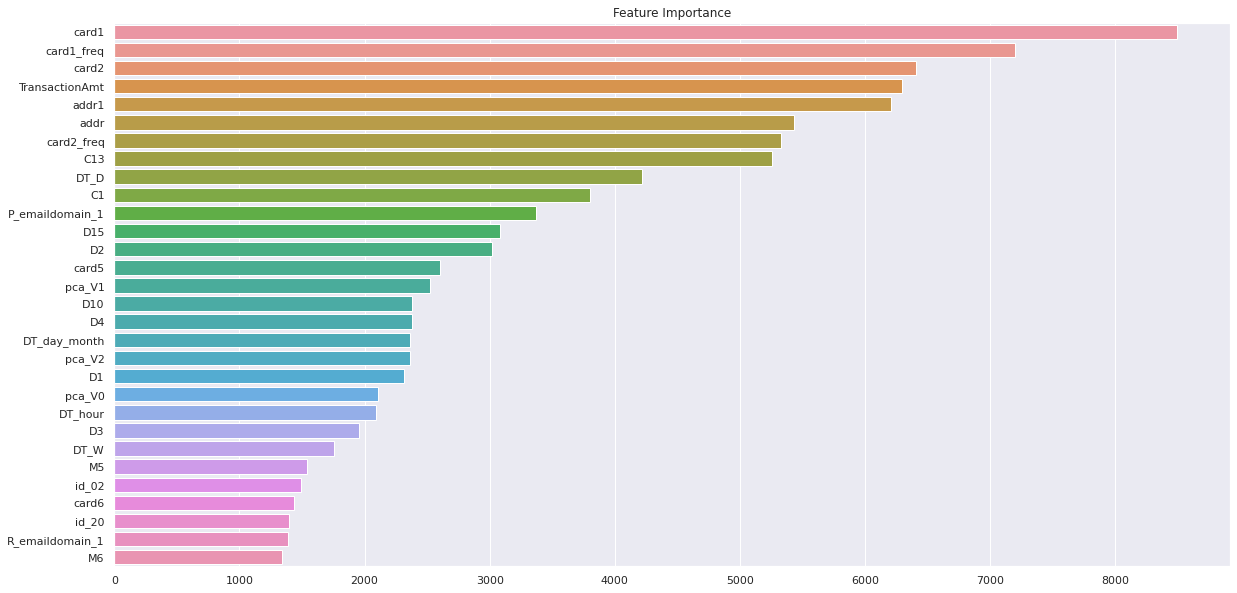

In [442]:
plot_feature_importances(lgb, 30)

In [443]:
y_pred = lgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    142469
           1       0.31      0.83      0.45      5166

    accuracy                           0.93    147635
   macro avg       0.65      0.88      0.71    147635
weighted avg       0.97      0.93      0.94    147635



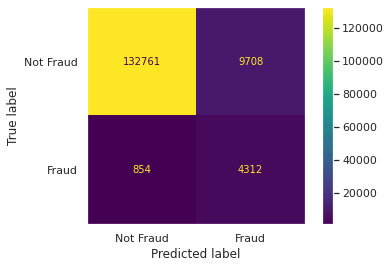

In [444]:
plot_confusion_matrix(lgb, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97    427408
           1       0.34      0.93      0.50     15497

    accuracy                           0.93    442905
   macro avg       0.67      0.93      0.73    442905
weighted avg       0.97      0.93      0.95    442905



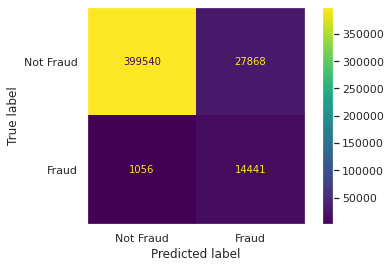

In [445]:
y_train_pred = lgb.predict(X_train)
plot_confusion_matrix(lgb, X_train, y_train, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_train, y_train_pred, zero_division=0))

In [446]:
print('Test ROC AUC score:', roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1]))
print('Train ROC AUC score:', roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1]))

Test ROC AUC score: 0.9534999017805633
Train ROC AUC score: 0.9838246815490457


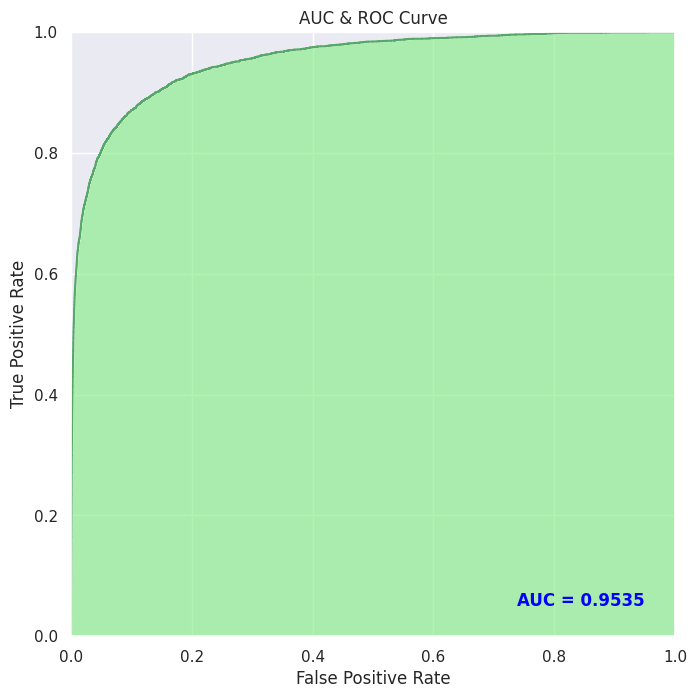

In [447]:
from sklearn import metrics

lgb.fit(X_train, y_train)
y_pred = lgb.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Saving Model

In [410]:
import pickle
pickle.dump(lgb,open("/content/drive/MyDrive/Colab Notebooks/Fraud Detection/LightGBM.pkl","wb"), protocol=4)

### Training with all train data

In [411]:
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']

In [412]:
# LGBMClassifier with GPU

clf = LGBMClassifier(
          max_bin = 63,
          num_leaves = 255,
          num_iterations = 500,
          learning_rate = 0.01,
          tree_learner = 'serial',
          is_dfing_metric = False,
          min_data_in_leaf = 1,
          min_sum_hessian_in_leaf = 100,
          sparse_threshold=1.0,
          # device = 'gpu',
          num_thread = -1,
          save_binary= True,
          seed= 42,
          feature_fraction_seed = 42,
          bagging_seed = 42,
          drop_seed = 42,
          data_random_seed = 42,
          objective = 'binary',
          boosting_type = 'gbdt',
          verbose = 1,
          metric = 'auc',
          is_unbalance = True,
          boost_from_average = False,
)

In [413]:
%time 
clf.fit(X, y)
# %time prints CPU Times and Wall Time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


LGBMClassifier(bagging_seed=42, boost_from_average=False, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, data_random_seed=42,
               drop_seed=42, feature_fraction_seed=42, importance_type='split',
               is_dfing_metric=False, is_unbalance=True, learning_rate=0.01,
               max_bin=63, max_depth=-1, metric='auc', min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=1, min_split_gain=0.0,
               min_sum_hessian_in_leaf=100, n_estimators=100, n_jobs=-1,
               num_iterations=500, num_leaves=255, num_thread=-1,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, save_binary=True, ...)

In [414]:
gc.collect()

17464

### Predict test data

In [415]:
sub= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/sample_submission.csv.zip')

In [416]:
sub['isFraud']=pd.DataFrame(clf.predict_proba(test))[[1]]

In [417]:
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/submission_last.csv',index=False)

In [418]:
sub

,TransactionID,isFraud
0,3663549,0.037879
1,3663550,0.068244
2,3663551,0.049095
3,3663552,0.129458
4,3663553,0.028449
...,...,...
506686,4170235,0.159609
506687,4170236,0.134854
506688,4170237,0.060009
506689,4170238,0.135091


## Modeling with XGBoost

In [419]:
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

In [420]:
xgb = XGBClassifier()

In [421]:
%time xgb.fit(X_train, y_train)

CPU times: user 2min 1s, sys: 466 ms, total: 2min 1s
Wall time: 2min 1s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [422]:
gc.collect()

211

In [424]:
y_pred = xgb.predict(X_test)

### Evaluation of XgGBoost

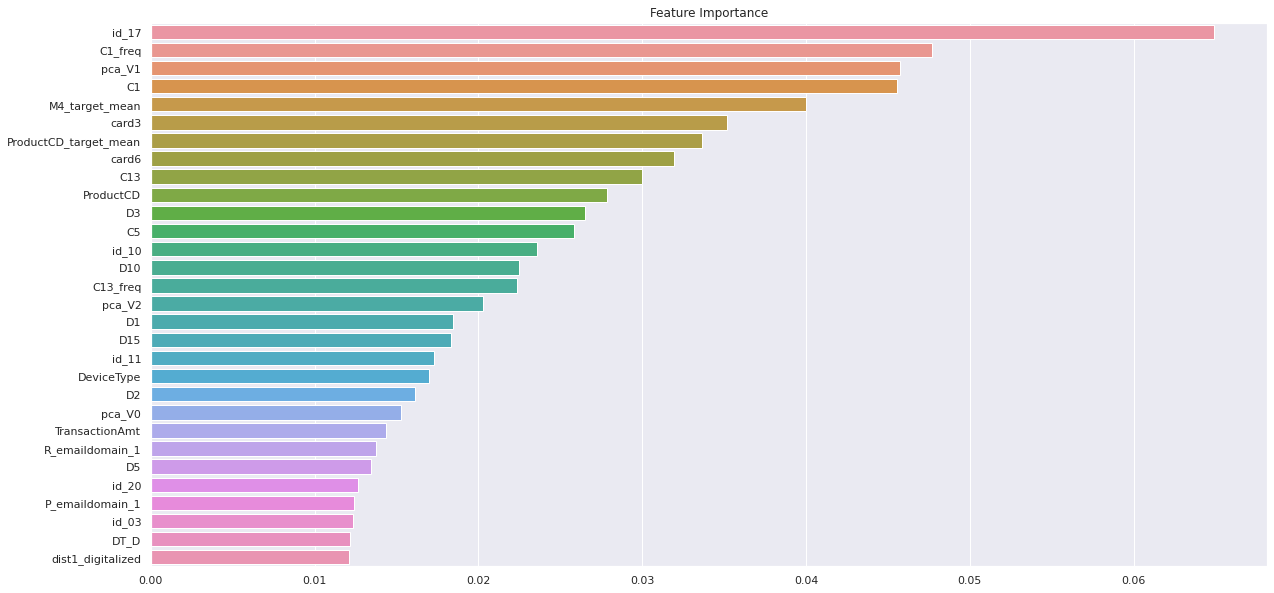

In [423]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()
    
plot_feature_importances(xgb, 30)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    142469
           1       0.86      0.27      0.41      5166

    accuracy                           0.97    147635
   macro avg       0.91      0.63      0.70    147635
weighted avg       0.97      0.97      0.97    147635



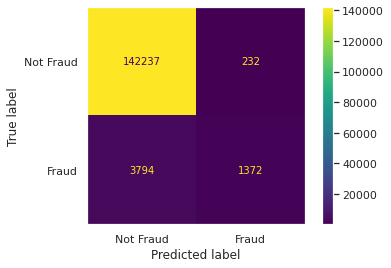

In [425]:
plot_confusion_matrix(xgb, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    427408
           1       0.86      0.26      0.40     15497

    accuracy                           0.97    442905
   macro avg       0.92      0.63      0.69    442905
weighted avg       0.97      0.97      0.97    442905



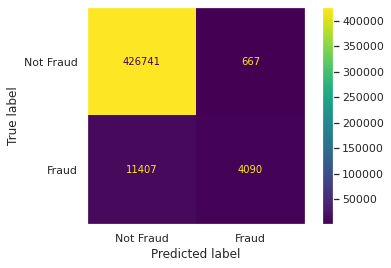

In [426]:
y_train_pred = xgb.predict(X_train)
plot_confusion_matrix(xgb, X_train, y_train, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_train, y_train_pred, zero_division=0))

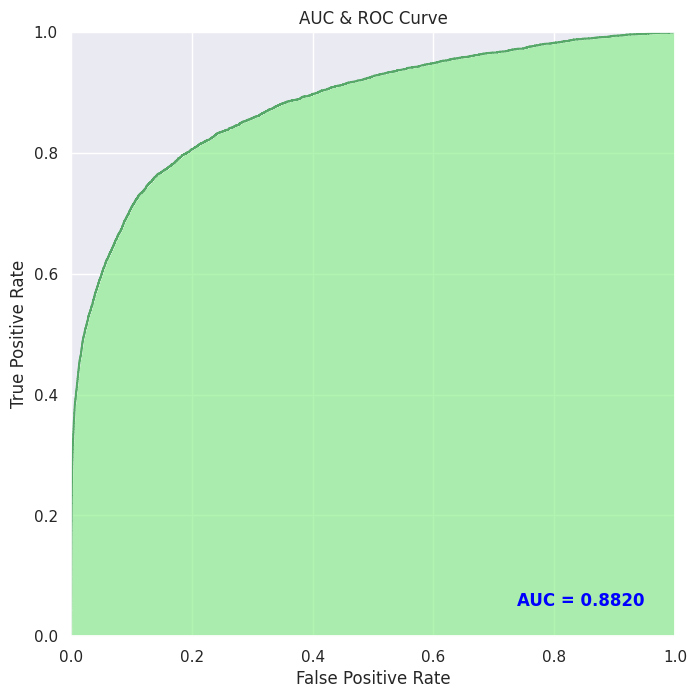

In [427]:
from sklearn import metrics

# xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Compare Models

In [452]:
y_pred = lgb.predict(X_test)
lgb_recall = recall_score(y_test, y_pred)
lgb_f1_score = f1_score(y_test, y_pred)
lgb_AUC = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])


y_pred = xgb.predict(X_test)
xgb_recall = recall_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred)
xgb_AUC = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1],average='micro')

In [453]:
df_eval=pd.DataFrame({ 'Model':["LightGBM",'XGBOOST'],
                        'Recall':[lgb_recall,xgb_recall],
                        'F1':[lgb_f1_score,xgb_f1_score],
                        'AUC':[lgb_AUC,xgb_AUC]})
df_eval

,Model,Recall,F1,AUC
0,LightGBM,0.834688,0.449494,0.953500
1,XGBOOST,0.265583,0.405318,0.882046


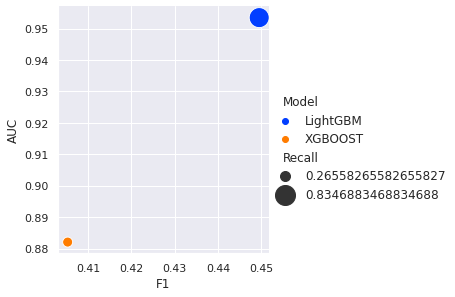

In [457]:
sns.relplot(x="F1", y="AUC", hue="Model", size="Recall", sizes=(100, 400), 
            alpha=1, palette="bright", height=4, legend='full', data=df_eval);

As seen above, LightGBM has done much better than XGBoost. It is also more successful than XGBoost in terms of training time and lower memory usage.

**Important Parameters of light GBM:**

`num_leaves`: the number of leaf nodes to use. Having a large number of leaves will improve accuracy, but will also lead to overfitting.

`min_child_samples`: the minimum number of samples (data) to group into a leaf. The parameter can greatly assist with overfitting: larger sample sizes per leaf will reduce overfitting (but may lead to under-fitting).

`max_depth`: controls the depth of the tree explicitly. Shallower trees reduce overfitting.

**Tuning for imbalanced data**

The simplest way to account for imbalanced or skewed data is to add weight to the positive class examples:

`scale_pos_weight`: the weight can be calculated based on the number of negative and positive examples: sample_pos_weight = number of negative samples / number of positive samples.

**Tuning for overfitting**

In addition to the parameters mentioned above the following parameters can be used to control overfitting:

`max_bin`: the maximum numbers of bins that feature values are bucketed in. A smaller max_binreduces overfitting.

`min_child_weight`: the minimum sum hessian for a leaf. In conjuction with min_child_samples, larger values reduce overfitting.
bagging_fraction and bagging_freq: enables bagging (subsampling) of the training data. Both values need to be set for bagging to be used. The frequency controls how often (iteration) bagging is used. Smaller fractions and frequencies reduce overfitting.

`feature_fraction`: controls the subsampling of features used for training (as opposed to subsampling the actual training data in the case of bagging). Smaller fractions reduce overfitting.
lambda_l1 and lambda_l2: controls L1 and L2 regularization.

**Tuning for accuracy**

Accuracy may be improved by tuning the following parameters:

`max_bin`: a larger max_bin increases accuracy.

`learning_rate`: using a smaller learning rate and increasing the number of iterations may improve accuracy.

`num_leaves`: increasing the number of leaves increases accuracy with a high risk of overfitting.